# Test to see if VAE can produce a good model

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from util import random_observation_sequence, transform_observations

In [170]:
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

o, a, r = random_observation_sequence(env, 4096)
# o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
o_scaled = transform_observations(o, observation_max, observation_min, [0, 0])
o_scaled

array([[0.4443481 , 0.5       ],
       [0.44363574, 0.49084106],
       [0.44239965, 0.48410753],
       ...,
       [0.35148658, 0.41183006],
       [0.3439957 , 0.4036885 ],
       [0.33618928, 0.39963185]])

In [175]:
enc = create_encoder(2, 2, [20])
dec = create_decoder(2, 2, [20])

vae = VAE(enc, dec, [0, 0], [0.3, 0.3], llik_scaling=1000000, kl_scaling=1)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [176]:
vae.fit(o_scaled, epochs=20, batch_size=64)

Epoch 1/20


2022-08-05 09:35:45.032835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 2s 23ms/step - loss: 694563.8272 - reconstruction_loss: 692658.1250 - kl_loss: 7.9593
Epoch 2/20
16/16 [==============================] - 0s 11ms/step - loss: 687684.4412 - reconstruction_loss: 686989.2500 - kl_loss: 7.0016
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 684260.3676 - reconstruction_loss: 684002.2500 - kl_loss: 6.6674
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 682220.4265 - reconstruction_loss: 681780.3125 - kl_loss: 6.6413
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 680713.6324 - reconstruction_loss: 680649.8125 - kl_loss: 6.6230
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 680257.2022 - reconstruction_loss: 679712.7500 - kl_loss: 6.4871
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 679668.0110 - reconstruction_loss: 679247.9375 - kl_loss: 6.2259
Epoch 8/20
16/16 [==============================] 

In [173]:
o_scaled

array([[0.4443481 , 0.5       ],
       [0.44363574, 0.49084106],
       [0.44239965, 0.48410753],
       ...,
       [0.35148658, 0.41183006],
       [0.3439957 , 0.4036885 ],
       [0.33618928, 0.39963185]])

In [174]:
vae(o_scaled)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[0.30486178, 0.4336493 ],
       [0.4439383 , 0.54062766],
       [0.41541928, 0.46143237],
       ...,
       [0.47370058, 0.53873515],
       [0.51931304, 0.53330016],
       [0.35853595, 0.4369621 ]], dtype=float32)>

In [29]:
a = np.random.random((100, 2))
vae.decoder(a)

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[0.37518728, 0.4894246 ],
       [0.3734936 , 0.48822287],
       [0.36795327, 0.48412043],
       [0.3670117 , 0.484143  ],
       [0.38132215, 0.49441734],
       [0.3803811 , 0.49602962],
       [0.37199798, 0.48713404],
       [0.36572155, 0.4837453 ],
       [0.36640424, 0.4833987 ],
       [0.36714956, 0.48486206],
       [0.37582153, 0.48941264],
       [0.37596548, 0.49572447],
       [0.35149646, 0.47657195],
       [0.3846336 , 0.4961655 ],
       [0.3614956 , 0.48020732],
       [0.37209067, 0.48700848],
       [0.35718486, 0.48053756],
       [0.36536002, 0.48376405],
       [0.37735426, 0.49476093],
       [0.36873078, 0.48457542],
       [0.38088804, 0.4932334 ],
       [0.38093433, 0.49468377],
       [0.36484897, 0.48438194],
       [0.34998766, 0.4749647 ],
       [0.37071866, 0.4892286 ],
       [0.37639737, 0.4929357 ],
       [0.35325596, 0.4771693 ],
       [0.36219457, 0.48085365],
       [0.3756031 , 0.4931

## MNIST

In [85]:
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train/255
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]**2)

In [86]:
x_train.max()

1.0

In [208]:
enc = create_encoder(10, 784, [256, 128])
dec = create_decoder(10, 784, [256, 128])

vae = VAE(enc, dec, [0]*10, [1]*10, llik_scaling=100, kl_scaling=1)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [209]:
vae.fit(x_train_flat, batch_size=64, epochs=20)

Epoch 1/20


2022-08-05 09:56:52.973505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 10s 9ms/step - loss: 32.0656 - reconstruction_loss: 26.0213 - kl_loss: 1.0857
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 24.9682 - reconstruction_loss: 23.2636 - kl_loss: 1.4521
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 23.8953 - reconstruction_loss: 21.0532 - kl_loss: 2.5935
Epoch 4/20
938/938 [==============================] - 9s 9ms/step - loss: 23.2038 - reconstruction_loss: 20.0597 - kl_loss: 3.0766
Epoch 5/20
938/938 [==============================] - 9s 9ms/step - loss: 22.9454 - reconstruction_loss: 19.5753 - kl_loss: 3.3404
Epoch 6/20
938/938 [==============================] - 9s 9ms/step - loss: 22.7353 - reconstruction_loss: 19.0522 - kl_loss: 3.6307
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 22.5322 - reconstruction_loss: 18.6739 - kl_loss: 3.8276
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 22.4113 - reconstru

In [210]:
out = vae(x_train_flat)
out = out.numpy().reshape(out.shape[0], 28, 28)
out.shape

(60000, 28, 28)

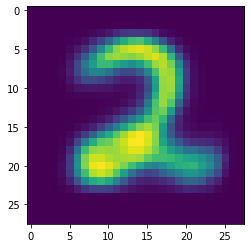

In [221]:
example = 16
plt.imshow(out[example])

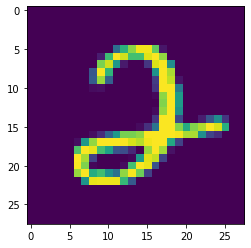

In [222]:
plt.imshow(x_train[example])

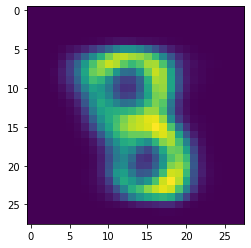

In [198]:
z = np.random.normal([0]*10, scale=[1]*10, size=(1, 10))
fake_num = vae.decoder(z).numpy().reshape(28,28)
plt.imshow(fake_num)